# EEG Statistics

Using some of the data you collected, we are going to go through a couple of different ways to discern whether the difference in signal between your conditions is statistically significant.

#### Setting up Python
Before starting to analyse our own EEG data, we need to make sure we have our virtual environment we created during the `MNE-tutorial`.

1. Press `Select Kernel`, then `Python Environments...` and then choose any Python kernel. 
2. Run the code chunk below
3. Change the kernel used to run the code in this notebook. Press where it says `Python X.XX.XX` in the top right corner, then `Select Another Kernel`, then `Jupyter kernel...` and then select `env`. If `env` does not show up, press the little refresh symbol! 

In [44]:
!bash ../env_to_ipynb_kernel.sh

Installed kernelspec env in /home/ucloud/.local/share/jupyter/kernels/env


#### Import packages

In [45]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path

# importing Lauras homemade functions for preprocessing
import sys
sys.path.append("..")
from helper_functions import preproc_subject, update_event_ids, update_events_group1_group2, event_id

# ICA TO CLEAN!


In [46]:
!pip install scikit-learn
import sklearn

In [47]:
l_freq = 1
h_freq = 40

tmin = -0.2
tmax = 0.5

baseline = (None, 0)
reject = {"eeg":150e-6}

In [48]:
# Load raw data 
# reading the file & loading in the data
# path to the data folder 
data_folder = Path("/work/EEG_lab/raw")
group_number= "6"

# path to the data - MAKE SURE TO CHANGE PATH ACCORDING TO YOUR GROUP NUMBER!
data_path = data_folder / "EEG" / f"group{group_number}.vhdr"

raw = mne.io.read_raw_brainvision(data_path)
raw.load_data()

montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

events, _ = mne.events_from_annotations(raw)

bad_channels = ["Fp1", "Fp2", "O1"]

# remove bad channels
raw.info["bads"] = bad_channels
raw.interpolate_bads(reset_bads = True)
    
# bandpass filter
raw.filter(l_freq, h_freq)

raw.crop(tmin = 250, tmax = None)
    
ica = mne.preprocessing.ICA(n_components=0.99, random_state=7, max_iter=800)
ica.fit(raw)



Extracting parameters from /work/EEG_lab/raw/EEG/group6.vhdr...
Setting channel info structure...
Reading 0 ... 864039  =      0.000 ...   864.039 secs...


Used Annotations descriptions: [np.str_('New Segment/'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32'), np.str_('Stimulus/S 40'), np.str_('Stimulus/S111'), np.str_('Stimulus/S112'), np.str_('Stimulus/S113'), np.str_('Stimulus/S114'), np.str_('Stimulus/S121'), np.str_('Stimulus/S122'), np.str_('Stimulus/S123'), np.str_('Stimulus/S124'), np.str_('Stimulus/S131'), np.str_('Stimulus/S132'), np.str_('Stimulus/S133'), np.str_('Stimulus/S134'), np.str_('Stimulus/S141'), np.str_('Stimulus/S142'), np.str_('Stimulus/S143'), np.str_('Stimulus/S144'), np.str_('Stimulus/S161'), np.str_('Stimulus/S162'), np.str_('Stimulus/S163'), np.str_('Stimulus/S169'), np.str_('Stimulus/S172'), np.str_('Stimulus/S179'), np.str_('Stimulus/S181'), np.str_('Stimulus/S182'), np.str_('Stimulus/S183'), np.str_('Stimulus/S189'), np.str_

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 13 components
Fitting ICA took 13.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,23 iterations on raw data (614040 samples)
ICA components,13
Available PCA components,31
Channel types,eeg
ICA components marked for exclusion,—


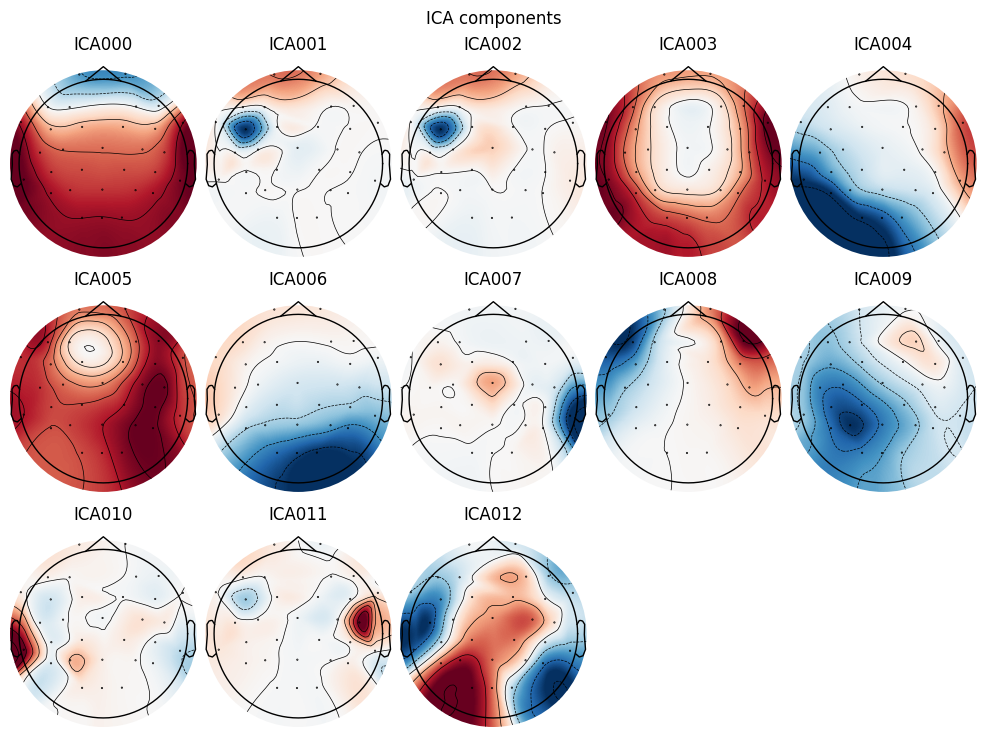

Creating RawArray with float64 data, n_channels=13, n_times=614040
    Range : 250000 ... 864039 =    250.000 ...   864.039 secs
Ready.


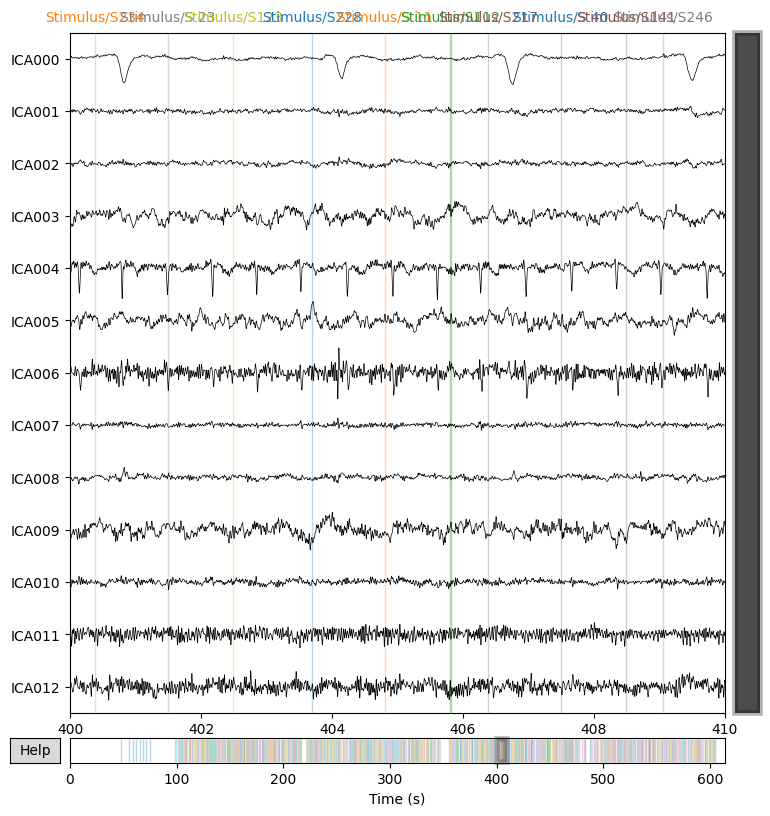

In [49]:
ica.plot_components();
ica.plot_sources(raw, start = 400, stop = 410);

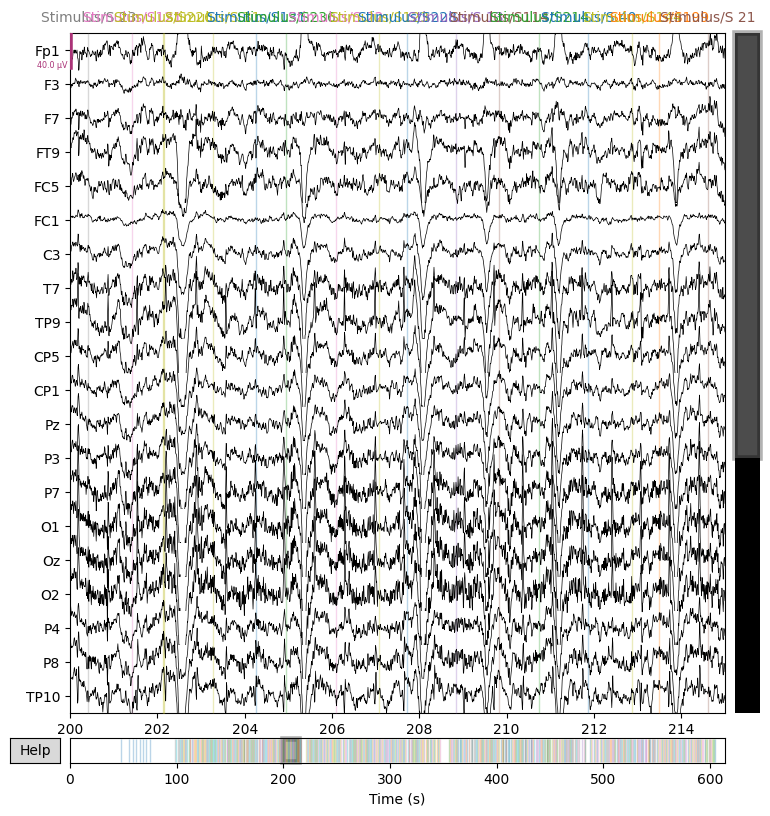

In [50]:
# before removing the noise
raw.plot(start = 200, duration = 15);

In [51]:
# LOOKING AT THE TIME COURSES (the signal in each component across time) AND TOPO PLOTS (the colorful heads from above) 
# I decide to remove ICA 000, 004, 008

# 000 = eyeblinks
# 004 = heart beats (?)
# 008 = side ways eye movement



ica.exclude = [0, 4, 8]
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 31 PCA components


<RawBrainVision | group6.eeg, 32 x 614040 (614.0 s), ~150.0 MB, data loaded>

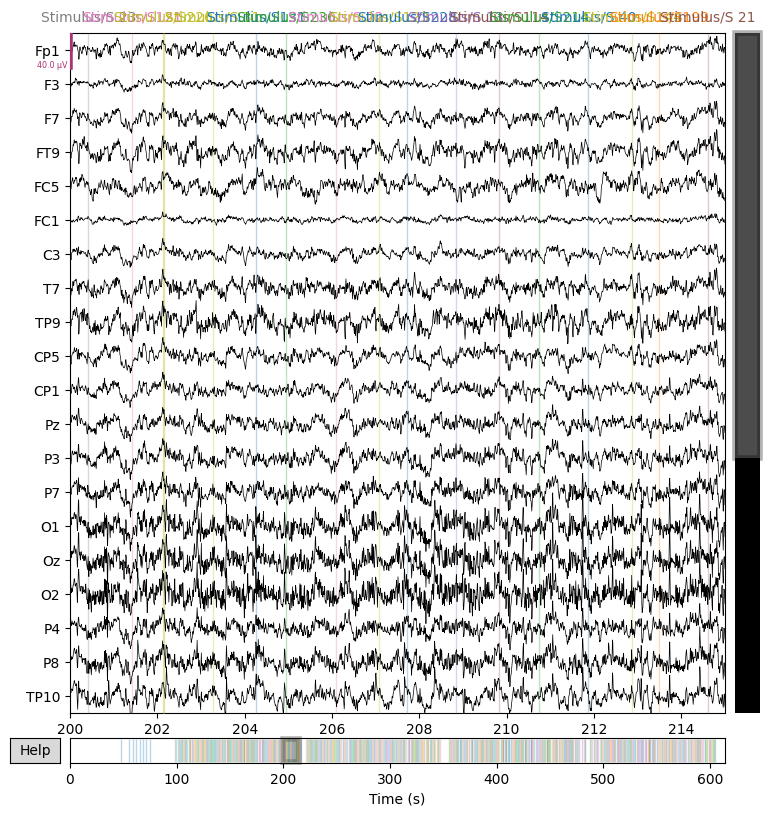

In [52]:
# PLOTTING BEFORE REMOVING NOISE
raw.plot(start = 200, duration = 15);

In [53]:
# Make epochs with more clean data
epochs = mne.Epochs(
    raw, events, update_event_ids(events, event_id), 
    tmin, tmax, 
    baseline = baseline, reject = reject, preload = True)

Not setting metadata
504 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 504 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
1 bad epochs dropped


Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated


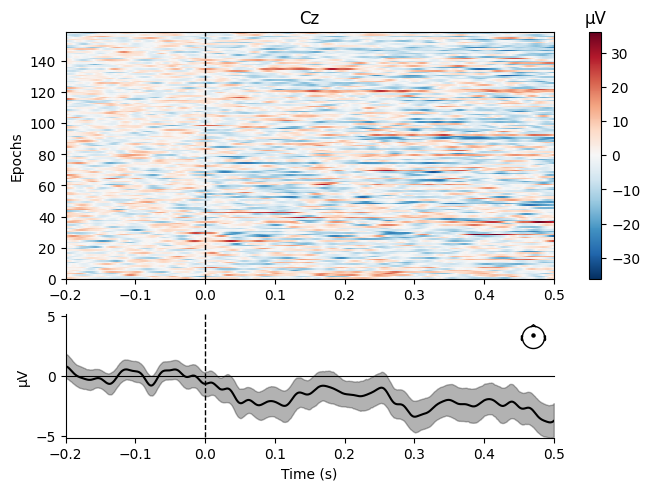

Not setting metadata
159 matching events found
No baseline correction applied
0 projection items activated


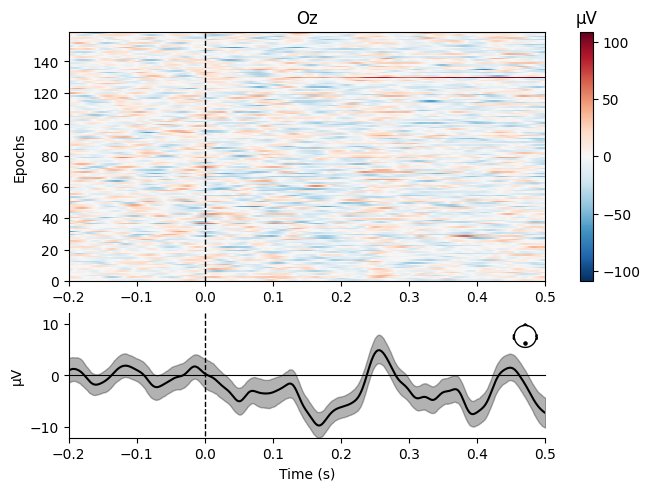

[<Figure size 640x480 with 4 Axes>]

In [71]:
# just showing a test plot 
word_epochs = epochs["word/prime"]

word_epochs.plot_image(picks = ["Cz"])
word_epochs.plot_image(picks = ["Oz"])

# Stats
Okay, now it is time for you to make some decisions! At this point you need to choose a contrast:
1. 'word/target/female' & 'word/target/male'

2. 'word/congruent' & 'word/incongruent'

3. 'word/prime' & 'word/target'


In [58]:
# Extract the contrast you are interested in using the following code as an example
epochs_condition1 = epochs["word/target/female"]
epochs_condition2 = epochs["word/target/female"]

In [59]:
# lets check which events were included
print(epochs_condition1)
print(epochs_condition2)

<Epochs | 53 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~9.1 MB, data loaded,
 'word/target/female/congruent': 8
 'word/target/female/incongruent': 6
 'word/target/female/neutral': 2
 'word/target/female/filler': 9
 'word/target/neutral/female': 8
 'word/target/control/female': 20>
<Epochs | 53 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~9.1 MB, data loaded,
 'word/target/female/congruent': 8
 'word/target/female/incongruent': 6
 'word/target/female/neutral': 2
 'word/target/female/filler': 9
 'word/target/neutral/female': 8
 'word/target/control/female': 20>


## Windowed mean
Now we have our two conditions: trials with words vs images. One of the simplest way in which we can determine whether the signal in our two conditions are statistically significant is by:

1) Segmenting our data using only certain channels in a specific time window. Keep in mind that which time window and channels should be established a priori, for instance according to the literature. 
2) Taking the mean of that window across channels and and samples.
3) Running statistical tests on the windowed means from the two conditions.

In an experiment with multiple participants we would also average over trials from individual participants, in order to only have one data point per participant (and thereby avoid multiple comparisons). However, since we have one participant, we can keep one dimension of the individual data, i.e. the trials.

### T-test
We can now do a t-test on the trials from the two conditions, to establish whether the means of the two groups are statistically significant.

We can use the get_data() function to get the numerical values of the signal (in microvolts) for the t-test. tmin and tmax are used to define the size of the window, and the picks are the channels that we expect to see an effect in.

In [60]:
# INSERT CHANNEL NAMES YOU ARE INTERESTED IN BELOW
picks = ["xxx", "xxx", "xxx"]


# DETERMINE THE TIME FRAME YOU WANT TO LOOK AT (remember to write it in seconds )
tmin_ttest = # insert number here
tmax_ttest = # insert number here


SyntaxError: invalid syntax (2116187778.py, line 6)

In [ ]:
# Now we can extract the data using the following logic
data_condition1 = epochs_condition1.get_data(picks = picks, tmin = tmin_ttest, tmax = tmax_ttest)
data_condition2 = epochs_condition2.get_data(picks = picks, tmin = tmin_ttest, tmax = tmax_ttest)

Investigating the resulting data; how many dimensions does the data have? What do you think they represent (i.e. which dimension is channels, trials, etc.)?

In [ ]:
print(data_condition1.shape)
print(data_condition2.shape)

Now we can average over the data so we only have the trials dimension.

In [ ]:
data_condition1_mean = np.mean(data_condition1, axis=2) # averaging over the third dimension of the data
print(data_condition1_mean.shape)

data_condition1_mean = np.mean(data_condition1_mean, axis=1) # averaging over the second dimension of the data
print(data_condition1_mean.shape)

## Now do the same for the second condition!

# INSERT CODE HERE

### Running the t-test

In [3]:
# installing additional packages
from scipy import stats as st
import statistics as stats

In [ ]:
# running the t-test
st.ttest_ind(a=data_condition1_mean, b=data_condition2_mean)

### Creating a nice plot to go with the t-test


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

times = epochs.times

# plot the time window used for the t-test
ax.axvspan(tmin, tmax, color="grey", alpha=0.2, label = "Time window for t-test")

data_condition1_plot = epochs_condition1.get_data(picks = picks).mean(axis=(1,2)) # also extracting the data outside of the time window to show the entire epoch duration
data_condition2_plot = epochs_condition2.get_data(picks = picks).mean(axis=(1,2))


ax.plot(times, data_condition1_plot, label="Nonword", linestyle="-", color="orange")
ax.plot(times, data_condition2_plot, label="Word", linestyle="-", color="blue")

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP (INSERT CHOSEN CHANNEL NAMES HERE) ")
ax.legend()
plt.savefig("figure1.png")